# Классификация знаков Дорожного Движения

In [1]:
# !pip install natsort

In [2]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from skimage import transform

print(f'Tensorflow version {tf.__version__}')
print(f'GPU is {"ON" if tf.compat.v1.config.experimental.list_physical_devices("GPU") else "OFF" }')


import numpy as np
import matplotlib, random
import matplotlib.pyplot as plt
import pandas as pd 
import cv2
import os

from imutils import paths
import os
import pathlib
import LRFinder
from natsort import natsorted

Tensorflow version 2.10.0
GPU is ON


In [3]:
data = []
labels = []
sumu =0
start = 0
input_size = (60,60)
path = "./New_Dataset/Forbidding_signs/"
num_classes = len(os.listdir(path))
for file_number in os.listdir(path):
    path2 = str(path+file_number)
    num = 0
    count=0
    for file_number_2 in os.listdir(path2):
        path3 = str(path2 + '/' + file_number_2)
#         if count == 500: break
        count = count+1
        imagepath = (path3)
#         print(imagepath)
        image = cv2.imread(imagepath, 1) ## Считываем изображение
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB) ## переводим в оттенки серого
        image = transform.resize(image, input_size)
        data.append(image)

        label = file_number
        labels.append(label)
    num = num + count
    sumu = sumu+count
    print(label, num)
print('all',sumu)

0 203
1 2213
10 2003
15 623
16 826
17 2206
2 2243
3 1403
32 233
4 1973
41 233
42 233
5 1853
6 413
7 1433
72 173
73 209
74 173
75 173
76 173
77 173
78 209
79 209
8 1403
80 209
81 245
82 173
83 173
84 173
85 173
86 173
87 245
88 209
89 281
9 1463
90 281
91 281
92 1145
93 533
94 461
95 353
96 209
97 173
all 27939


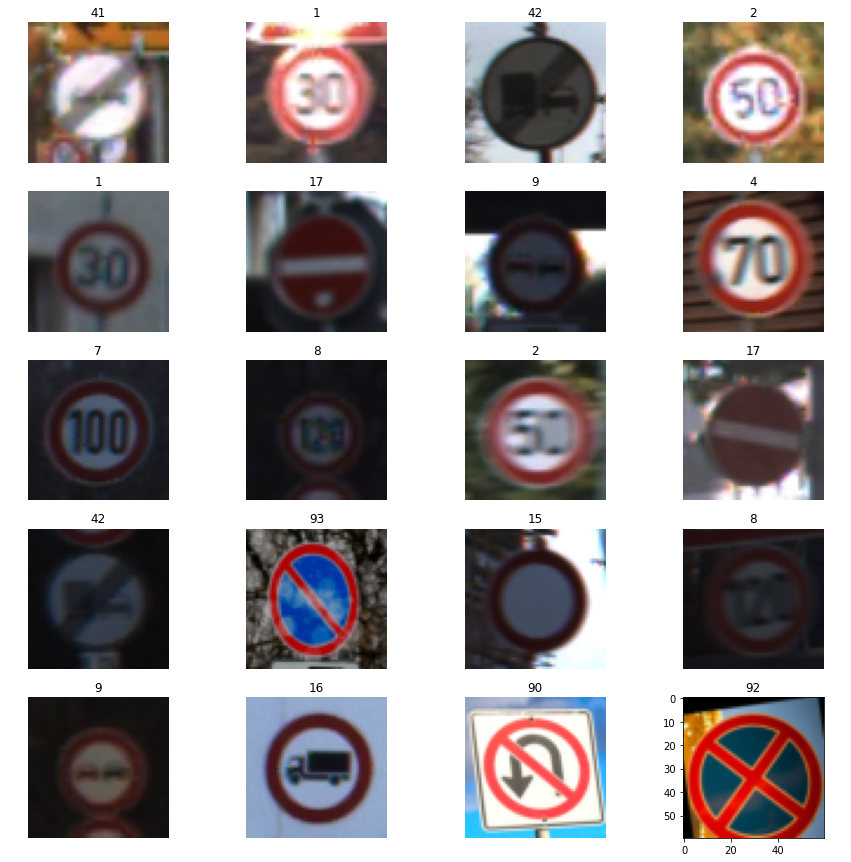

In [4]:
fig = plt.figure(figsize=(15, 15))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    z = random.randint(1,len(labels))
    plt.axis('off') 
    fig.add_subplot(rows, columns, i)
    plt.title(labels[z])
    plt.imshow(data[z])
plt.show()

In [5]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
labels = le.fit_transform(labels)


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, labels, random_state = 42, test_size = 0.3, stratify = labels)

from keras.utils import to_categorical
#Converting the labels into one hot encoding
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [6]:
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D,UpSampling2D,ZeroPadding2D, Dense, Flatten, Dropout, BatchNormalization , Input, ReLU
from keras import initializers
import math
import tensorflow_addons as tfa

from keras.optimizers import SGD, Adam

opt = SGD(learning_rate=0.008)
# opt = Adam(learning_rate=0.0001)
# opt = SGD()
initializer = initializers.RandomUniform(-1.0 / math.sqrt(512), 1.0 / math.sqrt(512), seed=42)

model = Sequential()
model.add(Input(shape=np.array(X_train).shape[1:]))

# model.add(ZeroPadding2D(padding=1))
model.add(Conv2D(filters=32, kernel_size=3, activation = 'swish'))
# model.add(ReLU())

model.add(MaxPool2D(pool_size=2))
model.add(Dropout(rate=0.05))

model.add(ZeroPadding2D(padding=1))
model.add(Conv2D(filters=64, kernel_size=3, activation = 'swish'))
# model.add(ReLU())

model.add(MaxPool2D(pool_size=2))
model.add(Dropout(rate=0.1))

# model.add(ZeroPadding2D(padding=1))
model.add(Conv2D(filters=128, kernel_size=3, activation = 'swish'))
# model.add(ReLU())

model.add(MaxPool2D(pool_size=2))
model.add(Dropout(rate=0.15))

# model.add(ZeroPadding2D(padding=2))
model.add(Conv2D(filters=256, kernel_size=5, activation = 'swish'))
# model.add(ReLU())

model.add(MaxPool2D(pool_size=2))
model.add(Dropout(rate=0.2))

model.add(BatchNormalization (momentum=0.9, epsilon=1e-5))


model.add(Flatten()) # по кол-ву пикселей из 2д в 1д
model.add(Dense(128, activation='swish')) # кол-во нейронов в слое
model.add(Dense(64, activation='swish')) # кол-во нейронов в слое
model.add(Dense(32, activation='swish')) # кол-во нейронов в слое
model.add(Dense(num_classes, kernel_initializer=initializer, bias_initializer=initializer, activation='softmax'))  # кол-во нейронов на выходе, по кол-ву классов


model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics=tfa.metrics.F1Score(num_classes=num_classes))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 58, 58, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 29, 29, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 29, 29, 32)        0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0

In [7]:
# lr_finder = LRFinder.LRFinder(model)
# lr_finder.find(np.array(X_train), np.array(y_train), start_lr=0.00001, end_lr=1, batch_size=10, epochs=20)
# lr_finder.plot_loss(n_skip_beginning=20, n_skip_end=5)

In [8]:
history = model.fit(np.array(X_train), np.array(y_train), batch_size=5, epochs=50, validation_data=(np.array(X_test), np.array(y_test)))

Epoch 1/50
3912/3912 [==============================] - 45s 11ms/step - loss: 2.5229 - f1_score: 0.1142 - val_loss: 1.6272 - val_f1_score: 0.2304
Epoch 2/50
3912/3912 [==============================] - 43s 11ms/step - loss: 1.2878 - f1_score: 0.4090 - val_loss: 0.6833 - val_f1_score: 0.6072
Epoch 3/50
3912/3912 [==============================] - 43s 11ms/step - loss: 0.7453 - f1_score: 0.6429 - val_loss: 0.3887 - val_f1_score: 0.8035
Epoch 4/50
3912/3912 [==============================] - 43s 11ms/step - loss: 0.5002 - f1_score: 0.7839 - val_loss: 0.2610 - val_f1_score: 0.8789
Epoch 5/50
3912/3912 [==============================] - 43s 11ms/step - loss: 0.3767 - f1_score: 0.8321 - val_loss: 0.1563 - val_f1_score: 0.9366
Epoch 6/50
3912/3912 [==============================] - 43s 11ms/step - loss: 0.2980 - f1_score: 0.8757 - val_loss: 0.1530 - val_f1_score: 0.9346
Epoch 7/50
3912/3912 [==============================] - 43s 11ms/step - loss: 0.2474 - f1_score: 0.8979 - val_loss: 0.0905 -

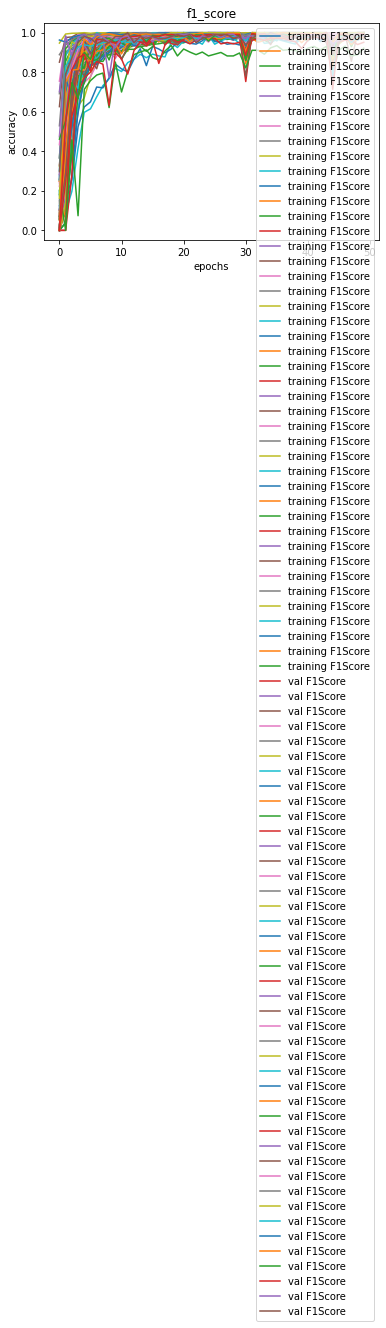

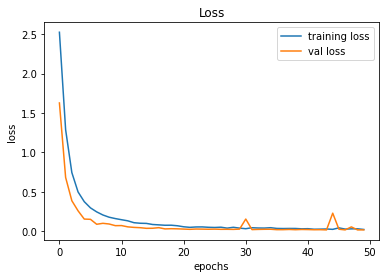

In [9]:
#plotting graphs for accuracy 
plt.figure(0)
plt.plot(history.history['f1_score'], label='training F1Score')
plt.plot(history.history['val_f1_score'], label='val F1Score')
plt.title('f1_score')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()
plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [21]:
# model.save('./saved_models/Trafic_Signs_CNN_forb_signs.h5')

In [11]:
forb_signs_classes = {'0':0,
'1':1,
'2':10,
'3':15,
'4':16,
'5':17,
'6':2,
'7':3,
'8':32,
'9':4,
'10':41,
'11':42,
'12':5,
'13':6,
'14':7,
'15':72,
'16':73,
'17':74,
'18':75,
'19':76,
'20':77,
'21':78,
'22':79,
'23':8,
'24':80,
'25':81,
'26':82,
'27':83,
'28':84,
'29':85,
'30':86,
'31':87,
'32':88,
'33':89,
'34':9,
'35':90,
'36':91,
'37':92,
'38':93,
'39':94,
'40':95,
'41':96,
'42':97,}

In [12]:
from sklearn.metrics import f1_score
df = pd.read_csv('./Data_images/Test_data.csv')
all_classes = []
predicted_classes = []
all_num = 60

In [13]:
for c in range (11):
    for i in range(all_num):
        
        all_classes.append(c)
        # Считываем тестовый датасет
        image_path = df.loc[df['ClassId'] == c].values[i][1]
        classid = df.loc[df['ClassId'] == c].values[i][0]
        
        # Обрабатываем изображения
        image = cv2.imread(str('./Data_images/' + str(image_path)), 1) ## Считываем изображение
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB) ## переводим в оттенки серого
        image_resized = transform.resize(image, input_size)
        img_batch = np.expand_dims(image_resized,0)
        
        # Начинаем предсказание категории знака
        prediction = model.predict(img_batch)
        prediction = np.argmax(prediction, axis=1)
        predicted_classes.append(forb_signs_classes[str(prediction[0])])
        
        if classid != forb_signs_classes[(str(prediction[0]))]:
             print(classid,forb_signs_classes[(str(prediction[0]))], prediction[0], image_path)


1/1 [==============================] - 0s 16ms/step
0 8 23 Test/11804.png
1/1 [==============================] - 0s 24ms/step
0 8 23 Test/05945.png
1/1 [==============================] - 0s 24ms/step
0 1 1 Test/04333.png
1/1 [==============================] - 0s 17ms/step
0 8 23 Test/06854.png
1/1 [==============================] - 0s 18ms/step
1 8 23 Test/03147.png
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 17ms/step
3 5 12 Test/09076.png
1/1 [==============================] - 0s 17ms/step
3 5 12 Test/08198.png
1/1 [==============================] - 0s 16ms/step
4 1 1 Test/06213.png
1/1 [==============================] - 0s 16ms/step
4 8 23 Test/09080.png
1/1 [==============================] - 0s 16ms/step
4 8 23 Test/09733.png
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
5 2 6 Test/00860.png
1/1 [==============================] - 0s 16ms/step
6 42 11 Test/10676.png
1/1 [==============================] - 0s 15ms/step
6 42 11 Test/06184.png
1/1 [==============================] - 0s 16ms/step
6 5 12 Test/09545.png
1/1 [==============================] - 0s 17ms/step
6 15 3 Test/11070.png
1/1 [==============================] - 0s 18ms/step
6 5 12 Test/05521.png
1/1 [==============================] - 0s 16ms/step
6 8 23 Test/00537.png
1/1 [==============================] - 0s 15ms/step
6 5 12 Test/08770.png
1/1 [==============================] - 0s 16ms/step
6 5 12 Test/07928.png
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
7 5 12 Test/09623.png
1/1 [==============================] - 0s 16ms/step
8 6 13 Test/07967.png
1/1 [==============================] - 0s 16ms/step
8 5 12 Test/07957.png
1/1 [==============================] - 0s 16ms/step
9 10 2 Test/06889.png
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


In [14]:
for c in range (15, 18):
    for i in range(all_num):
        
        all_classes.append(c)
        # Считываем тестовый датасет
        image_path = df.loc[df['ClassId'] == c].values[i][1]
        classid = df.loc[df['ClassId'] == c].values[i][0]
        
        # Обрабатываем изображения
        image = cv2.imread(str('./Data_images/' + str(image_path)), 1) ## Считываем изображение
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB) ## переводим в оттенки серого
        image_resized = transform.resize(image, input_size)
        img_batch = np.expand_dims(image_resized,0)
        
        # Начинаем предсказание категории знака
        prediction = model.predict(img_batch)
        prediction = np.argmax(prediction, axis=1)
        predicted_classes.append(forb_signs_classes[str(prediction[0])])
        
        if classid != forb_signs_classes[(str(prediction[0]))]:
             print(classid,forb_signs_classes[(str(prediction[0]))], prediction[0], image_path)


1/1 [==============================] - 0s 16ms/step
16 9 34 Test/11178.png
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


In [15]:
for c in range (32,33):
    for i in range(all_num):
        
        all_classes.append(c)
        # Считываем тестовый датасет
        image_path = df.loc[df['ClassId'] == c].values[i][1]
        classid = df.loc[df['ClassId'] == c].values[i][0]
        
        # Обрабатываем изображения
        image = cv2.imread(str('./Data_images/' + str(image_path)), 1) ## Считываем изображение
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB) ## переводим в оттенки серого
        image_resized = transform.resize(image, input_size)
        img_batch = np.expand_dims(image_resized,0)
        
        # Начинаем предсказание категории знака
        prediction = model.predict(img_batch)
        prediction = np.argmax(prediction, axis=1)
        predicted_classes.append(forb_signs_classes[str(prediction[0])])
        
        if classid != forb_signs_classes[(str(prediction[0]))]:
             print(classid,forb_signs_classes[(str(prediction[0]))], prediction[0], image_path)


1/1 [==============================] - 0s 17ms/step


In [16]:
for c in range (41,43):
    for i in range(all_num):
        
        all_classes.append(c)
        # Считываем тестовый датасет
        image_path = df.loc[df['ClassId'] == c].values[i][1]
        classid = df.loc[df['ClassId'] == c].values[i][0]
        
        # Обрабатываем изображения
        image = cv2.imread(str('./Data_images/' + str(image_path)), 1) ## Считываем изображение
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB) ## переводим в оттенки серого
        image_resized = transform.resize(image, input_size)
        img_batch = np.expand_dims(image_resized,0)
        
        # Начинаем предсказание категории знака
        prediction = model.predict(img_batch)
        prediction = np.argmax(prediction, axis=1)
        predicted_classes.append(forb_signs_classes[str(prediction[0])])
        
        if classid != forb_signs_classes[(str(prediction[0]))]:
             print(classid,forb_signs_classes[(str(prediction[0]))], prediction[0], image_path)


1/1 [==============================] - 0s 16ms/step
41 9 34 Test/04105.png
1/1 [==============================] - 0s 16ms/step
41 9 34 Test/09462.png
1/1 [==============================] - 0s 16ms/step
41 9 34 Test/11201.png
1/1 [==============================] - 0s 16ms/step
41 9 34 Test/10698.png
1/1 [==============================] - 0s 15ms/step
41 9 34 Test/03593.png
1/1 [==============================] - 0s 15ms/step
41 9 34 Test/01763.png
1/1 [==============================] - 0s 16ms/step
41 9 34 Test/02980.png
1/1 [==============================] - 0s 16ms/step
41 9 34 Test/06261.png
1/1 [==============================] - 0s 16ms/step


In [17]:
for c in range (72, 98):
    for i in range(all_num):
        
        all_classes.append(c)
        # Считываем тестовый датасет
        image_path = df.loc[df['ClassId'] == c].values[i][1]
        classid = df.loc[df['ClassId'] == c].values[i][0]
        
        # Обрабатываем изображения
        image = cv2.imread(str('./Data_images/' + str(image_path)), 1) ## Считываем изображение
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB) ## переводим в оттенки серого
        image_resized = transform.resize(image, input_size)
        img_batch = np.expand_dims(image_resized,0)
        
        # Начинаем предсказание категории знака
        prediction = model.predict(img_batch)
        prediction = np.argmax(prediction, axis=1)
        predicted_classes.append(forb_signs_classes[str(prediction[0])])
        
        if classid != forb_signs_classes[(str(prediction[0]))]:
             print(classid,forb_signs_classes[(str(prediction[0]))], prediction[0], image_path)


1/1 [==============================] - 0s 16ms/step
72 90 35 Test/72_6_18.png
1/1 [==============================] - 0s 17ms/step
73 76 19 Test/73_4_6.png
1/1 [==============================] - 0s 16ms/step
73 41 10 Test/73_4_17.png
1/1 [==============================] - 0s 16ms/step
73 76 19 Test/73_3_11_16.png
1/1 [==============================] - 0s 16ms/step
73 86 30 Test/73_4_3.png
1/1 [==============================] - 0s 16ms/step
73 76 19 Test/73_3_10.png
1/1 [==============================] - 0s 16ms/step
73 76 19 Test/73_4_35.png
1/1 [==============================] - 0s 16ms/step
73 76 19 Test/73_4_33.png
1/1 [==============================] - 0s 17ms/step
73 76 19 Test/73_3_11.png
1/1 [==============================] - 0s 21ms/step
73 4 9 Test/73_2_34.png
1/1 [==============================] - 0s 16ms/step
73 76 19 Test/73_2_26.png
1/1 [==============================] - 0s 16ms/step
73 2 6 Test/73_4_13.png
1/1 [==============================] - 0s 16ms/step
73 41 10 Test/7

1/1 [==============================] - 0s 16ms/step
74 76 19 Test/74_2_17.png
1/1 [==============================] - 0s 16ms/step
74 41 10 Test/74_7_18.png
1/1 [==============================] - 0s 16ms/step
74 75 18 Test/74_2_1.png
1/1 [==============================] - 0s 17ms/step
75 76 19 Test/75_5_6.png
1/1 [==============================] - 0s 17ms/step
75 76 19 Test/75_5_19.png
1/1 [==============================] - 0s 16ms/step
75 82 26 Test/75_4_22.png
1/1 [==============================] - 0s 15ms/step
75 74 17 Test/75_3_16.png
1/1 [==============================] - 0s 16ms/step
75 74 17 Test/75_3_10.png
1/1 [==============================] - 0s 21ms/step
75 76 19 Test/75_5_5.png
1/1 [==============================] - 0s 15ms/step
75 74 17 Test/75_3_24.png
1/1 [==============================] - 0s 16ms/step
75 1 1 Test/75_6_5.png
1/1 [==============================] - 0s 16ms/step
75 76 19 Test/75_5_2.png
1/1 [==============================] - 0s 17ms/step
75 76 19 Test/75_5_

1/1 [==============================] - 0s 16ms/step
77 2 6 Test/77_5_29.png
1/1 [==============================] - 0s 17ms/step
77 2 6 Test/77_4_8.png
1/1 [==============================] - 0s 16ms/step
77 4 9 Test/77_4_21.png
1/1 [==============================] - 0s 17ms/step
77 2 6 Test/77_4_32.png
1/1 [==============================] - 0s 16ms/step
77 87 31 Test/77_4_28.png
1/1 [==============================] - 0s 17ms/step
77 4 9 Test/77_4_18.png
1/1 [==============================] - 0s 17ms/step
78 85 29 Test/78_5_21.png
1/1 [==============================] - 0s 16ms/step
78 96 41 Test/78_4_37.png
1/1 [==============================] - 0s 16ms/step
78 83 27 Test/78_2_12.png
1/1 [==============================] - 0s 16ms/step
78 91 36 Test/78_6_0.png
1/1 [==============================] - 0s 15ms/step
78 85 29 Test/78_5_26.png
1/1 [==============================] - 0s 16ms/step
78 85 29 Test/78_5_9.png
1/1 [==============================] - 0s 16ms/step
78 96 41 Test/78_4_19.png

1/1 [==============================] - 0s 16ms/step
79 72 15 Test/79_5_17.png
1/1 [==============================] - 0s 16ms/step
81 15 3 Test/81_3_35.png
1/1 [==============================] - 0s 16ms/step
81 8 23 Test/81_1_22.png
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
82 81 25 Test/82_2_25.png
1/1 [==============================] - 0s 16ms/step
82 84 28 Test/82_1_14.png
1/1 [==============================] - 0s 16ms/step
83 88 32 Test/83_1_16.png
1/1 [==============================] - 0s 16ms/step
84 9 34 Test/84_2_28.png
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 15ms/step
84 83 27 Test/84_1_8.png
1/1 [==============================] - 0s 15ms/step
85 9 34 Test/85_3_18.png
1/1 [==============================] - 0s 16ms/step
85 93 38 Test/85_7_14.png
1/1 [==============================] - 0s 17ms/step
85 86 30 Test/85_1_18.png
1/1 [==============================] - 0s 16ms/step
85 93 38 Test/85_7_5.png
1/1 [==============================] - 0s 15ms/step
85 87 31 Test/85_3_6.png
1/1 [==============================] - 0s 16ms/step
85 87 31 Test/85_3_8.png
1/1 [==============================] - 0s 15ms/step
85 86 30 Test/85_1_28.png
1/1 [==============================] - 0s 17ms/step
85 84 28 Test/85_7_2.png
1/1 [==============================] - 0s 15ms/step
85 81 25 Test/85_7_6.png
1/1 [==============================] - 0s 16ms/step
85 1 1 Test/85_3_5.png
1/1 [==============================] - 0s 16ms/step
85 76 19 Test/85_1_26.png
1/1 [==============================] - 0s 18ms/step
85 87 31 Test/85_3_36.

1/1 [==============================] - 0s 15ms/step
88 77 20 Test/88_3_21.png
1/1 [==============================] - 0s 16ms/step
88 84 28 Test/88_3_12.png
1/1 [==============================] - 0s 17ms/step
88 75 18 Test/88_2_16.png
1/1 [==============================] - 0s 16ms/step
88 90 35 Test/88_1_5.png
1/1 [==============================] - 0s 17ms/step
89 78 21 Test/89_3_10.png
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step
90 88 32 Test/90_6_19.png
1/1 [==============================] - 0s 17ms/step
91 75 18 Test/91_5_18.png
1/1 [==============================] - 0s 15ms/step
91 77 20 Test/91_5_9.png
1/1 [==============================] - 0s 16ms/step
91 77 20 Test/91_5_14.png
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 15ms/step
93 92 37 Test/93_6_11.png
1/1 [==============================] - 0s 16ms/step
93 94 39 Test/93_4_19.png
1/1 [==============================] - 0s 17ms/step
93 78 21 Test/93_7_5.png
1/1 [==============================] - 0s 16ms/step
93 92 37 Test/93_6_16.png
1/1 [==============================] - 0s 16ms/step
93 94 39 Test/93_3_1.png
1/1 [==============================] - 0s 18ms/step
94 93 38 Test/94_5_10.png
1/1 [==============================] - 0s 17ms/step
94 85 29 Test/94_7_30.png
1/1 [==============================] - 0s 17ms/step
94 92 37 Test/94_6_17.png
1/1 [==============================] - 0s 17ms/step
94 2 6 Test/94_7_22.png
1/1 [==============================] - 0s 16ms/step
94 92 37 Test/94_5_0.png
1/1 [==============================] - 0s 16ms/step
94 2 6 Test/94_7_14.png
1/1 [==============================] - 0s 15ms/step
94 5 12 Test/94_7_2.png
1/1 [==============================] - 0s 15ms/step
94 88 32 Test/94_7_6.

1/1 [==============================] - 0s 16ms/step
94 5 12 Test/94_2_9.png
1/1 [==============================] - 0s 16ms/step
94 95 40 Test/94_6_2.png
1/1 [==============================] - 0s 16ms/step
95 94 39 Test/95_1_14.png
1/1 [==============================] - 0s 16ms/step
95 94 39 Test/95_7_17.png
1/1 [==============================] - 0s 15ms/step
95 92 37 Test/95_7_14.png
1/1 [==============================] - 0s 16ms/step
95 92 37 Test/95_5_29.png
1/1 [==============================] - 0s 16ms/step
95 92 37 Test/95_4_13.png
1/1 [==============================] - 0s 15ms/step
95 92 37 Test/95_6_28.png
1/1 [==============================] - 0s 15ms/step
96 1 1 Test/96_1_5.png
1/1 [==============================] - 0s 17ms/step
96 17 5 Test/96_4_28.png
1/1 [==============================] - 0s 20ms/step
97 96 41 Test/97_4_20.png
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
97 96 41 Test/97_4_17.png
1/1 [==============================] - 0s 17ms/step
97 17 5 Test/97_3_3.png
1/1 [==============================] - 0s 17ms/step
97 2 6 Test/97_4_16.png
1/1 [==============================] - 0s 16ms/step
97 96 41 Test/97_3_30.png
1/1 [==============================] - 0s 17ms/step


In [18]:
print (f1_score(all_classes, predicted_classes, average='weighted'))

0.9375082086035235


Text(0.5, 0.98, 'Plot of confusion matrix')

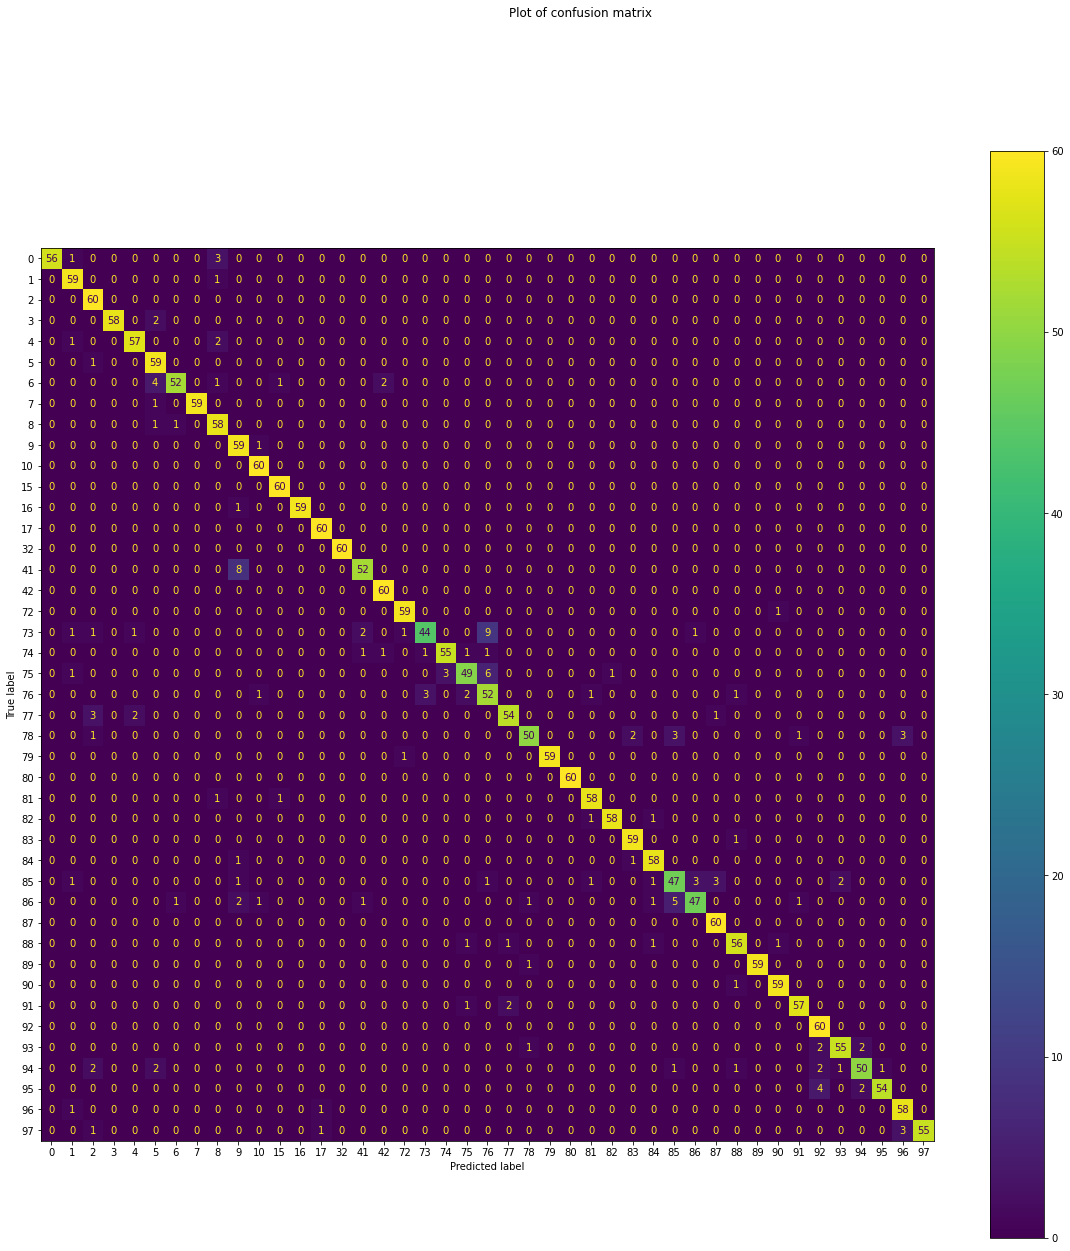

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
display = ConfusionMatrixDisplay.from_predictions(all_classes, predicted_classes)
fig = display.figure_
fig.set_figwidth(20)
fig.set_figheight(20) 
fig.suptitle('Plot of confusion matrix')